In [1]:
#Script for training AE at different latent dimension
#FHN Model
#Asif Hamid Bhat # 10-10-2023

In [1]:
### clear ram
# import torch
# with torch.no_grad():
#     torch.cuda.empty_cache()
# %reset

In [1]:
# imports
import os
import time
import sys
import numpy as np
import scipy as sp
from scipy import integrate, interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from os.path import dirname, join as pjoin
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error
from scipy.io import savemat, loadmat

import warnings
warnings.filterwarnings('ignore')
import torch
import os
import torch.nn as nn
import torch.optim as optim
criterion = torch.nn.MSELoss(reduction='none')
import matplotlib.pyplot as plt

# paths
noise = 0.0 
system = 'KS' #### FHN,KS 
data_dir = os.path.join('../data/', system)
model_dir = os.path.join('../models/', system)
path=os.path.join('../results/KS/data')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
module_path= os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from AERD import *
print(torch.cuda.is_available())

True


#### LOAD DATA

In [7]:
train_data = torch.load(data_dir + "/train_data.pt")
train_data=train_data[:10,:,:]
# train_data=train_data.transpose(1, 2)
# val_data = torch.load(data_dir + "/val_data.pt")
test_data = torch.load(data_dir + "/test_data.pt")
test_data=test_data[:,:,:]

In [9]:
train_data=torch.tensor(train_data).to(torch.float32).to(device)
test_data=torch.tensor(test_data).to(torch.float32).to(device)
tspan=train_data.shape[1]
train_data.shape,test_data.shape

(torch.Size([10, 5121, 120]), torch.Size([5, 5121, 120]))

In [10]:
# loop for different latent dimension
loop= np.arange(1,11,1)
mse_latentAE=torch.zeros(1,loop.shape[0])
# mse_PCA=torch.zeros(1,loop.shape[0])

In [12]:
# # Define the autoencoder class FOR KS,FHN
input_size=train_data.shape[2]
hidden_size=loop
L1=120
L2=120
L3=100
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self,i):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, L1),
            torch.nn.ReLU(),
            torch.nn.Linear(L1, L2),
            torch.nn.ReLU(),
            torch.nn.Linear(L2, L3),
            torch.nn.ReLU(),
            torch.nn.Linear(L3, hidden_size[i])
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_size[i], L3),
            torch.nn.ReLU(),
            torch.nn.Linear(L3, L2),
            torch.nn.ReLU(),
            torch.nn.Linear(L2, L1),
            torch.nn.ReLU(),
            torch.nn.Linear(L1,input_size)
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the training function
def train(model, dataloader, num_epochs, learning_rate,model_path=None):
    criterion = nn.MSELoss()
    print_interval=1000
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
    best_loss = 1e+5
    for epoch in range(num_epochs):
        for data in dataloader:
            recon = model(data)
            loss = criterion(recon, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % print_interval == 0:
            print('Epoch [{}/{}], Loss:{:.8e}'.format(epoch+1, num_epochs, loss.item()))
            if loss.item() < best_loss:
                best_loss = loss.item()
                print('(--> new model saved @ epoch {})'.format(epoch+1))
                best_model_state = model.state_dict()
                torch.save(best_model_state,model_path)
        # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [13]:
# train_data=train_data.to(torch.float32).to(device)
train_data=torch.tensor(train_data).to(torch.float32).to(device)
# val_data=val_data.to(torch.float32).to(device)
test_data=test_data.to(torch.float32).to(device)

In [15]:
epoch=10000
sets=train_data.shape[1]

# Example usage
dataloader = torch.utils.data.DataLoader(train_data, batch_size=32)
for i in range(len(loop)):
    # Create the autoencoder model
    modelAE = AE(i).to(device)
    print('Running testing for i =', i+1, ' of ',loop)
#     # Train the model
    save_path=model_dir+'/KSAE_D{}.pt'.format(i)
    train(modelAE, dataloader, num_epochs=epoch, learning_rate=1e-3,model_path=save_path)
    autoencoder_output=modelAE(test_data)
    #.cpu().detach().numpy()
    #### mse_latent[:,sample]=mean_squared_error(test_data.cpu().detach().numpy().reshape(test_data.shape[0]*test_data.shape[1],test_data.shape[2])
    # ###,autoencoder_output.cpu().detach().numpy().reshape(autoencoder_output.shape[0]*autoencoder_output.shape[1],autoencoder_output.shape[2]))
    ### Norm_latent[:,sample]=norm(test_data.detach().numpy()-autoencoder_output.detach().numpy())/norm(snapshots_test.detach().numpy())   
print('AE training done !')

Running testing for i = 1  of  [ 1  2  3  4  5  6  7  8  9 10]
Epoch [1000/20000], Loss:3.77734661e-01
(--> new model saved @ epoch 1000)
Epoch [2000/20000], Loss:3.26246262e-01
(--> new model saved @ epoch 2000)
Epoch [3000/20000], Loss:2.96038747e-01
(--> new model saved @ epoch 3000)
Epoch [4000/20000], Loss:2.92519867e-01
(--> new model saved @ epoch 4000)
Epoch [5000/20000], Loss:2.71964490e-01
(--> new model saved @ epoch 5000)
Epoch [6000/20000], Loss:2.66044319e-01
(--> new model saved @ epoch 6000)
Epoch [7000/20000], Loss:2.55233020e-01
(--> new model saved @ epoch 7000)
Epoch [8000/20000], Loss:2.58094788e-01
Epoch [9000/20000], Loss:2.43694767e-01
(--> new model saved @ epoch 9000)
Epoch [10000/20000], Loss:2.35189810e-01
(--> new model saved @ epoch 10000)
Epoch [11000/20000], Loss:2.40150392e-01
Epoch [12000/20000], Loss:2.31868967e-01
(--> new model saved @ epoch 12000)
Epoch [13000/20000], Loss:2.28461578e-01
(--> new model saved @ epoch 13000)
Epoch [14000/20000], Loss

In [149]:
### loading best AE models and check mse for testing data

In [16]:
sample=0
for i in range(len(loop)):
    print('Running testing for i =', i+1, ' of ',loop)   
    save_path=model_dir+'/KSAE_D{}.pt'.format(i)
    loaded_model = AE(i).to(device)
    loaded_model.load_state_dict(torch.load(save_path))
    autoencoder_output=loaded_model(test_data)
    mse_latentAE[:,sample]=criterion(torch.tensor(test_data).float(), torch.tensor(autoencoder_output).float()).mean(-1).mean()
    sample=sample+1

Running testing for i = 1  of  [ 1  2  3  4  5  6  7  8  9 10]
Running testing for i = 2  of  [ 1  2  3  4  5  6  7  8  9 10]
Running testing for i = 3  of  [ 1  2  3  4  5  6  7  8  9 10]
Running testing for i = 4  of  [ 1  2  3  4  5  6  7  8  9 10]
Running testing for i = 5  of  [ 1  2  3  4  5  6  7  8  9 10]
Running testing for i = 6  of  [ 1  2  3  4  5  6  7  8  9 10]
Running testing for i = 7  of  [ 1  2  3  4  5  6  7  8  9 10]
Running testing for i = 8  of  [ 1  2  3  4  5  6  7  8  9 10]
Running testing for i = 9  of  [ 1  2  3  4  5  6  7  8  9 10]
Running testing for i = 10  of  [ 1  2  3  4  5  6  7  8  9 10]


In [17]:
AE_loss=mse_latentAE.reshape(mse_latentAE.shape[1]).cpu().detach().numpy()
AE_loss.shape

(10,)

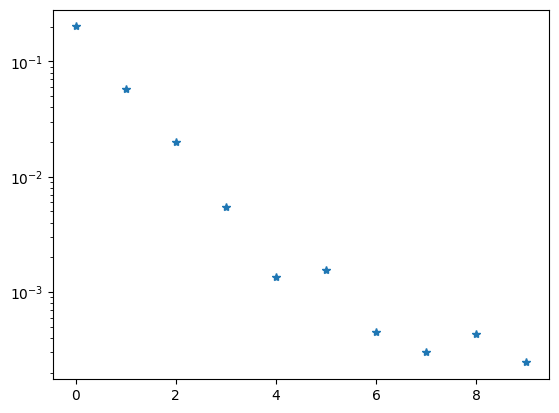

In [18]:
plt.semilogy(mse_latentAE.T,'*')
plt.show()

#### PCA

In [19]:
train_data.shape,test_data.shape

(torch.Size([10, 5121, 120]), torch.Size([5, 5121, 120]))

In [20]:
PCA_train=train_data[:,:,:]

In [21]:
train_data.shape
PCAdata=PCA_train.reshape(PCA_train.shape[0]*PCA_train.shape[1],PCA_train.shape[2])#[:train_data.shape[1]].reshape(train_data.shape[1],2*96*96).to(device)
print(PCAdata.shape)
PCAtest_data=test_data.reshape(test_data.shape[0]*test_data.shape[1],test_data.shape[2])#[:5120].reshape(5120,2*96*96).to(device)
# print(PCAtest_data.shape)

torch.Size([51210, 120])


In [22]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
recons_train=[]
recons_test=[]
latent_dims= loop#np.arange(1,13,1)
for n_comp in latent_dims:
    pca = PCA(n_components=n_comp) #define PCA model
    Xdr=pca.fit_transform(PCAdata.cpu().detach().numpy()) # obatain PCA modes from training data
    Xtr=pca.fit_transform(PCAtest_data.cpu().detach().numpy()) #project testing data on PCA modes
    Xt_approx=pca.inverse_transform(Xtr) #Back-project the testing data on original space
    mse_test=mean_squared_error(PCAtest_data.cpu().detach().numpy(),Xt_approx)
    recons_test.append(mse_test)
PCA_loss=recons_test

AE:  [0.20127594470977783, 0.057176291942596436, 0.019979702308773994, 0.005468179006129503, 0.0013390613021329045, 0.0015558983432129025, 0.00044592280755750835, 0.00029978761449456215, 0.00043372175423428416, 0.0002446057624183595]
PCA:  [0.98074174, 0.73042864, 0.5027473, 0.29643142, 0.19793345, 0.11385487, 0.07356788, 0.038829103, 0.024491576, 0.010183429]


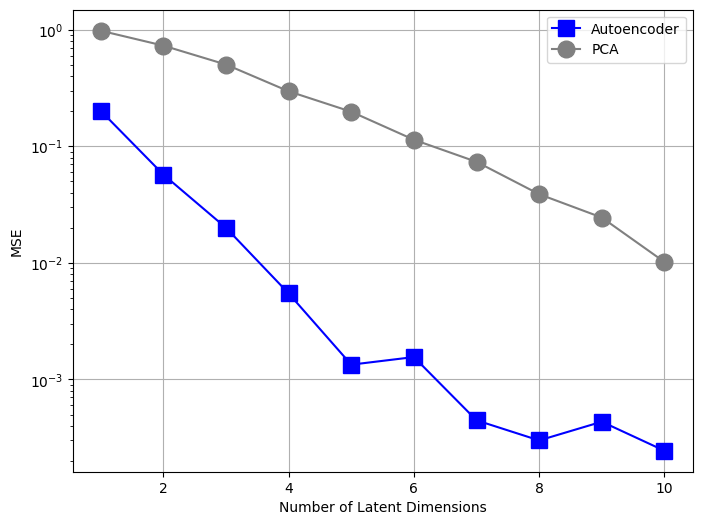

In [33]:
plt.figure(figsize=(8, 6))
plt.semilogy(latent_dims, AE_loss, marker='s',markersize=12,label='Autoencoder',color='blue')
plt.semilogy(latent_dims, recons_test, marker='o',markersize=12,label='PCA',color='gray')
# plt.title('Reconstruction Error vs Latent Dimensions for {} systems'.format(system))
plt.xlabel('Number of Latent Dimensions')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
figname='/KSAEvsPCA'
plt.savefig(path+figname, bbox_inches='tight')
# plt.show()


print('AE: ',[item.item() for item in AE_loss])
print('PCA: ',recons_test)

### Saving the variables

In [30]:
# torch tensor
mdic = {'AE_loss': AE_loss,'PCA_loss': PCA_loss}
savemat(path + '/KSmse_latent.mat', mdic)

In [57]:
print('done')

done
